Code written by Philipp Hennig and modified by Fabian Sinz.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from numpy.random import multivariate_normal
from scipy.linalg import cho_solve, cho_factor
import scipy.io
import seaborn as sns

In [3]:
# colors:
goeblue = '#153268'
midblue = '#0093c7'
grey60 = '#878787'
skyblue = '#84bfea'

## Gaussian inference on linear functions

In [14]:
def phi(a):  # phi(a) = [1,a]
    return np.power(a, range(4))

Some other options for the feature functions to try. Try around! Try scaling and changing the prior and/or the features (note that there are a few degrees of freedom shared between them)

In [17]:
def phi(a):
    # linear
    return 1 * (np.abs(a - np.linspace(-8, 8, 8).T)) - np.linspace(-8, 8, 8)

In [20]:
def phi(a):
    return 2 * (a > np.linspace(-8, 8, 8).T)  # steps that switch on

In [23]:
def phi(a):  # steps that change sign
    return 2 * ((a > np.linspace(-8, 8, 8).T) - 0.5)

In [26]:
def phi(a):
    # linear
    return 1 * (np.abs(a - np.linspace(-8, 8, 8).T) - np.linspace(-8, 8, 8))

In [29]:
def phi(a):  # Fourier features
    return 3 * np.hstack((np.sin(a * range(4)), np.cos(a * range(4))))

In [33]:
def phi(a):
    return 5 * np.exp(
        -((a - np.linspace(-8, 8, 12).T) ** 2) / 2.0 / 0.5 ** 2
    )  # Gaussian / RBF / SE features

In [36]:
def phi(a):  # "Eiffel towers"
    return 5 * np.exp(-np.abs(a - np.linspace(-8, 8, 12).T) / 1 ** 2)

# Equations for reference

$A^{-1}b$ same solution to $Ax=b$ (solve for $x$)

Distribution of $f_*$ at new data points $x_*$
$$\Large p\left(f_* \mid y,\Phi_{X}\right) = \mathcal{N}\left(f_* ; \mu_{f_*|y}, \Sigma_{f_*|y}\right)$$
with 
$$\Large \mu_{f_*|y} = \mu_{f_*} + \Sigma_{f_*y}\left(\Sigma_f+\sigma_{\varepsilon}^{2} I_n\right)^{-1}\left(y-\mu_f\right)$$
$$\Large \Sigma_{f_*|y} = \Sigma_{f_*}-\Sigma_{f_*y}\left(\Sigma_f+\sigma_{\varepsilon}^{2} I_n\right)^{-1} \Sigma_{yf_*}$$
$$\Large \Sigma_{y} = \Sigma_{f}+\sigma_{\varepsilon}^{2}I_{n}$$
$$\Large \Sigma_{f} = \Phi_{X}^{\top}\Sigma_{w}\Phi_{X}$$
$$\Large \Sigma_{f_*y} = \Phi_{X_*}^{\top}\Sigma_{w}\Phi_{X}$$
$$\Large\mu_{f_*}= \Phi_{X_*}^{\top}\mu$$

In [37]:
""" ==== PARAMETRIC GAUSSIAN REGRESSION IN PYTHON ====
    this is didactic code. 
    In practice, you can and should obviously write this 
    in a more re-usable (be it functional or object-oriented) 
    style. The point is to show that everything here involves
    simple low-level operations (at most, numpy.linalg). There 
    is no "deep learning package" here, and no stochastic optimizer. 
"""
# first, define the prior on w
F = len(phi(0))  # number of features
# set parameters of prior on the weights
mu = np.zeros((F, 1))
Sigma = np.eye(F)  # p(w)=N(mu,Sigma)

# construct implied prior on f_x
n = 100  # number of grid-points, for plotting
x = np.linspace(-8, 8, n)[:, np.newaxis]  # reshape is needed for phi to work
m = phi(x) @ mu # mean of functions
kxx = phi(x) @ Sigma @ phi(x).T  # prior p(f_x)=N(m,k_xx)
s = multivariate_normal(m.flatten(),kxx,size=5).T
stdpi = np.sqrt(np.diag(kxx))[:, np.newaxis]  # marginal stddev, for plotting

# then, load data from disk
dat = np.genfromtxt('data.csv', delimiter=',')
X, Y = dat.T
X, Y = X[:, np.newaxis], Y[:, np.newaxis] # add another dimension to make it work with the equations

sigma = 1.5 # measurement noise std-deviation
N = len(X)  # number of data

# evidence: p(Y) = N(Y;M,kXX + sigma**2 * np.eye(N))
M = phi(X) @ mu # mean function at the data points
kXX = phi(X) @ Sigma @ phi(X).T  # prior p(f_X) = N(M,k_XX)
G = kXX + sigma ** 2 * np.eye(N) # prior covariance of Y

# now, do inference (i.e. construct the posterior)
# the following in-place decomposition is the most expensive step at O(N^3):
G = cho_factor(G)
kxX = phi(x) @ Sigma @ phi(X).T  #  Cov(f_x, Y) = Cov(f_x,f_X) = k_xX
A = cho_solve(G, kxX.T).T  # pre-compute for re-use 

# posterior p(f_x|Y) = N(f_x,mpost,vpost)
mpost = m + A @ (Y - M)  # mean
vpost = kxx - A @ kxX.T  # covariance
spost = multivariate_normal(mpost.flatten(),vpost,size=5).T  # samples
stdpo = np.sqrt(np.diag(vpost))[:, np.newaxis]  # marginal stddev, for plotting

## plotting

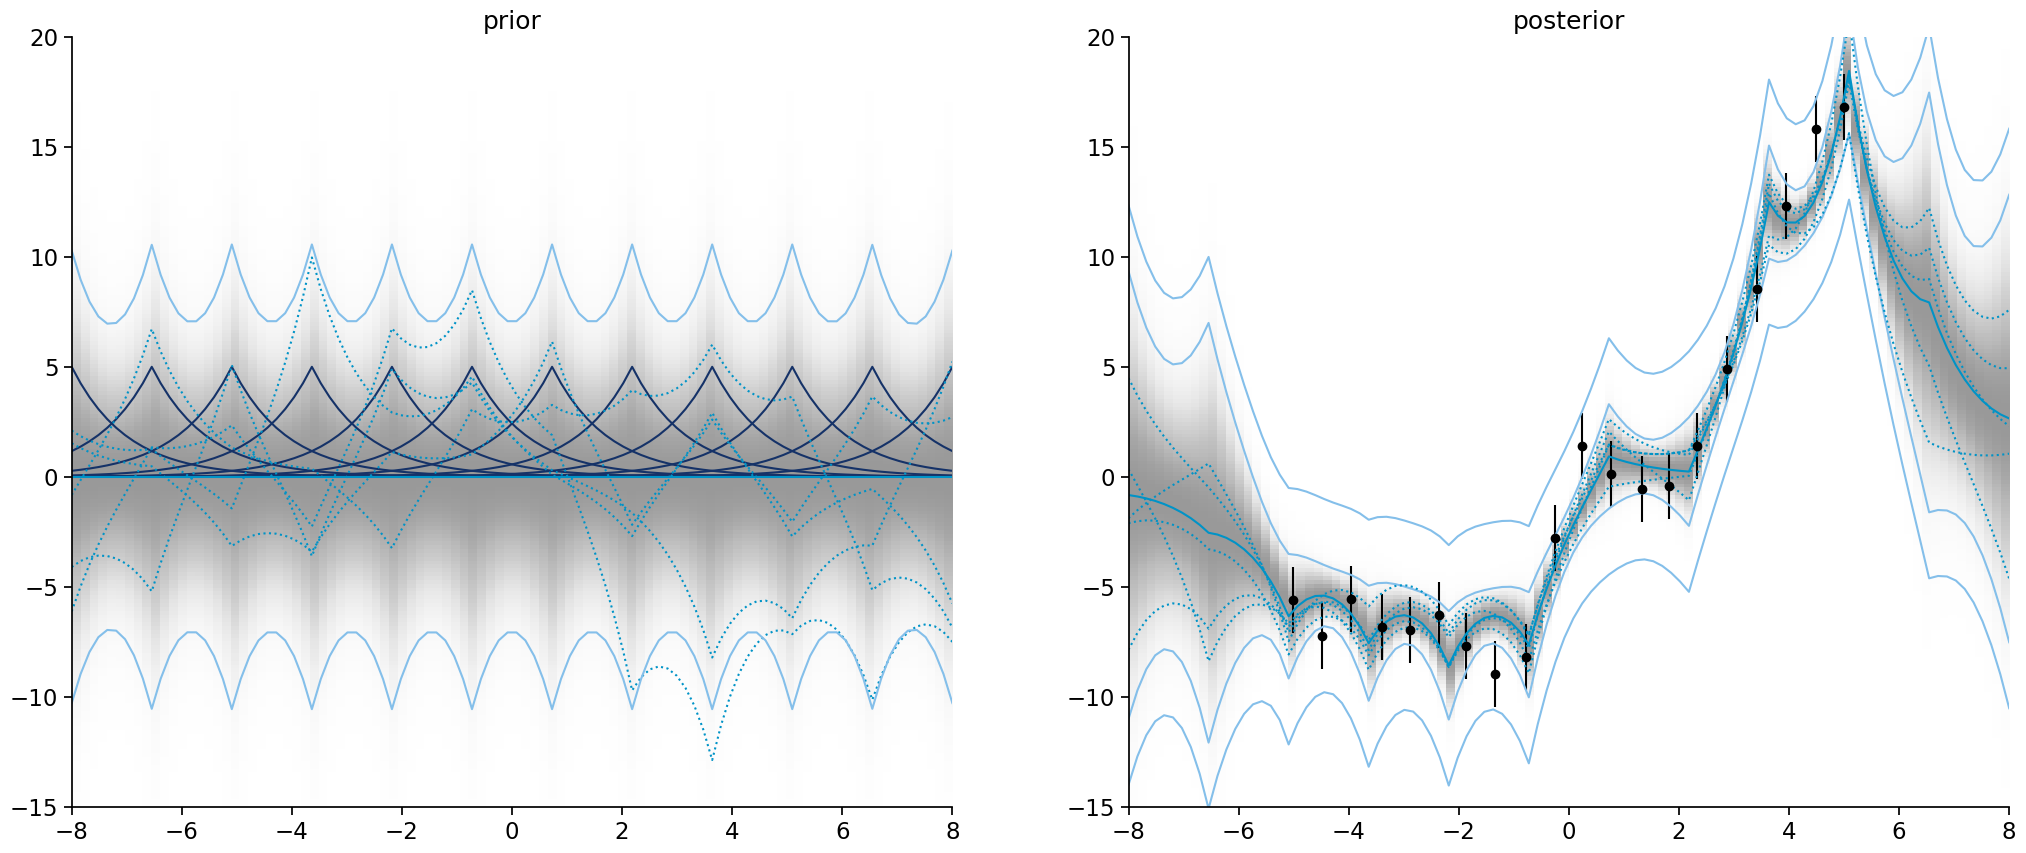

In [38]:
import matplotlib.pyplot as plt
sns.set_context('notebook', font_scale=1.5)
plt.rcParams["figure.figsize"] = (25, 10)
fig, ax = plt.subplots(1, 2)


def GaussPDFscaled(y, m, s):  # shading
    return np.exp(-0.5 * (y - m.T) ** 2 / (s ** 2).T)


yy = np.linspace(-15, 20, 200).reshape([200, 1])
P = GaussPDFscaled(yy, m, stdpi)

ax[0].imshow(
    P, extent=[-8, 8, -15, 20], aspect="auto", origin="lower", cmap="Greys", alpha=0.4
)
ax[0].plot(x, phi(x), "-", color=goeblue)
ax[0].plot(x, s, ":", color=midblue)  # prior
ax[0].plot(x, m, "-", color=midblue)
ax[0].plot(x, m + 2 * stdpi, "-", color=skyblue)
ax[0].plot(x, m - 2 * stdpi, "-", color=skyblue)
ax[0].set(xlim=[-8, 8], ylim=[-15, 20], title="prior")

Ppost = GaussPDFscaled(yy, mpost, stdpo)  # shading by local marginal pdf
ax[1].imshow(
    Ppost,
    extent=[-8, 8, -15, 20],
    aspect="auto",
    origin="lower",
    cmap="Greys",
    alpha=0.4,
)
ax[1].errorbar(X.ravel(), Y.ravel(), yerr=sigma, fmt="ok")  # data
ax[1].plot(x, mpost, "-", color=midblue)  # posterior mean
ax[1].plot(x, mpost + 2 * stdpo, "-", color=skyblue)  # upper error bars on f
ax[1].plot(x, mpost - 2 * stdpo, "-", color=skyblue)  # lower error bars on f

ax[1].plot(
    x, mpost + 2 * stdpo + 2 * sigma, "-", color=skyblue
)  # predictive error bars (on y)
ax[1].plot(x, mpost - 2 * stdpo - 2 * sigma, "-", color=skyblue)

ax[1].plot(x, spost, ":", color=midblue)  # samples
ax[1].set(xlim=[-8, 8], ylim=[-15, 20], title="posterior")

sns.despine(trim=True)
plt.show()